Universidade Estadual de Campinas – UNICAMP 

Disciplina: Ciência e Visualização de Dados em Saúde

                    Análise de dados da hanseníase: uma abordagem preditiva para a saúde pública

# Imports e configs de módulos

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
import imageio
from IPython.display import Image
import warnings

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 70)
%matplotlib inline
sns.set_style('darkgrid')
sns.set(font_scale=1.005)
warnings.filterwarnings('ignore')

# Datasets

In [4]:
df_hans = pd.read_csv('../data/interim/hans_pre_covid.csv')

In [5]:
df_hans.head()

,SG_UF_NOT,ID_MUNICIP,ID_REGIONA,ID_UNIDADE,DT_DIAG,ANO_NASC,CS_SEXO,CS_GESTANT,CS_RACA,CS_ESCOL_N,SG_UF,ID_MN_RESI,ID_RG_RESI,ID_OCUPA_N,FORMACLINI,AVALIA_N,CLASSOPERA,MODODETECT,BACILOSCOP,DTINICTRAT,ESQ_INI_N,UFATUAL,ID_MUNI_AT,DT_NOTI_AT,ID_UNID_AT,UFRESAT,MUNIRESAT,CLASSATUAL,AVAL_ATU_N,ESQ_ATU_N,EPIS_RACIO,NU_ANO,NU_LESOES,CONTREG,DOSE_RECEB,CONTEXAM,DTALTA_N,TPALTA_N
0,29.0,292700,1382.0,2653257.0,27/11/2008,1958.0,M,6.0,4.0,3.0,29.0,292700.0,1382.0,NaN,2.0,3.0,1.0,2.0,3.0,02/03/2009,1.0,BA,292700.0,01/01/2009,2653257.0,29.0,292700.0,1.0,3.0,1.0,4.0,2009,1.0,4.0,6.0,NaN,29/12/2009,1.0
1,21.0,210330,1434.0,2449706.0,01/01/2009,1943.0,M,6.0,4.0,1.0,21.0,210330.0,1434.0,NaN,4.0,1.0,2.0,1.0,1.0,23/10/2009,2.0,MA,210330.0,01/01/2009,2449706.0,21.0,210330.0,2.0,1.0,2.0,4.0,2009,10.0,6.0,12.0,1.0,22/09/2010,1.0
2,26.0,260290,1497.0,20389.0,13/10/2008,1994.0,F,9.0,NaN,NaN,26.0,260290.0,1497.0,999991.0,1.0,0.0,1.0,1.0,2.0,13/10/2008,1.0,PE,260290.0,02/01/2009,20389.0,26.0,260290.0,1.0,NaN,1.0,NaN,2009,1.0,3.0,NaN,3.0,22/05/2009,1.0
3,21.0,211290,1432.0,2455706.0,02/01/2009,1957.0,M,6.0,1.0,2.0,21.0,211290.0,1432.0,NaN,4.0,3.0,2.0,2.0,1.0,02/01/2009,2.0,MA,211290.0,02/01/2009,2455706.0,21.0,211290.0,2.0,3.0,2.0,4.0,2009,2.0,6.0,12.0,1.0,29/04/2010,1.0
4,35.0,354350,1575.0,2053381.0,18/12/2008,1968.0,M,6.0,1.0,1.0,35.0,354350.0,1575.0,NaN,1.0,0.0,2.0,1.0,1.0,18/12/2008,2.0,SP,354350.0,02/01/2009,2053381.0,35.0,354350.0,2.0,1.0,2.0,4.0,2009,1.0,2.0,NaN,2.0,18/12/2009,1.0


In [6]:
df_hans.shape

(309555, 38)

# EDA

### Análise de casos por estado

In [7]:
df_hans_states = df_hans['UFATUAL'].value_counts().to_frame().reset_index()
df_hans_states = df_hans_states.rename(columns={'index': 'UF', 'UFATUAL': 'Contagem'})
df_hans_states.head()

,UF,Contagem
0,MA,36401
1,PA,30764
2,MT,30068
3,PE,25421
4,BA,23579


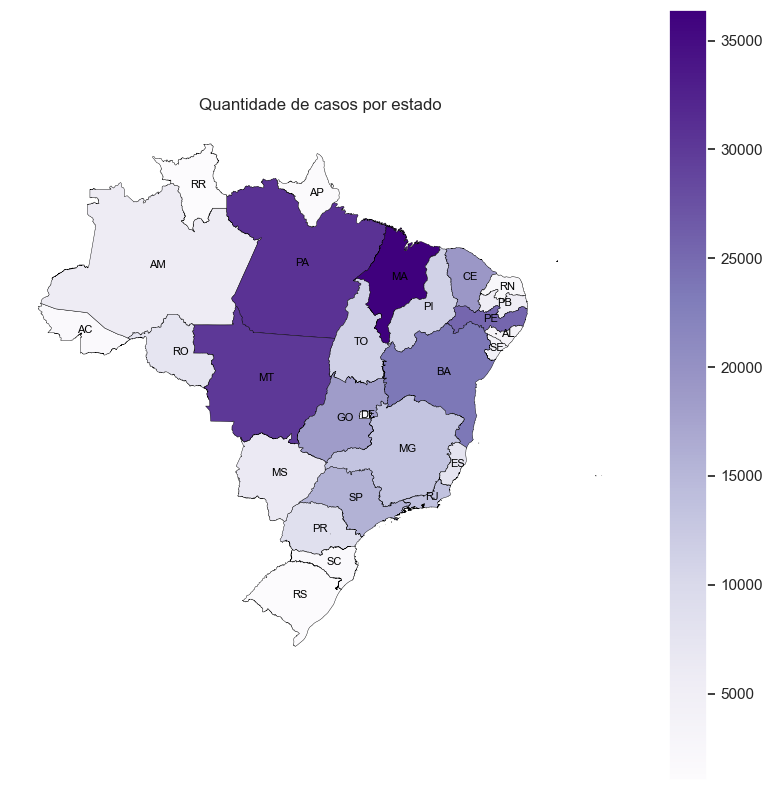

In [8]:
# Carrega o arquivo shapefile do mapa do Brasil
map = gpd.read_file('../assets/mapa/BR_UF_2022.shp')

# Combina o DataFrame com o GeoDataFrame do mapa
map_occurrences = map.merge(df_hans_states, left_on='SIGLA_UF', right_on='UF')

# Plot do mapa do Brasil com os dados
fig, ax = plt.subplots(figsize=(10, 10))
map_occurrences.plot(column='Contagem', cmap='Purples', edgecolor='black', linewidth = 0.3, ax=ax, legend=True)

# Adiciona as siglas das UFs
for x, y, label in zip(map_occurrences.geometry.centroid.x, map_occurrences.geometry.centroid.y, map_occurrences['SIGLA_UF']):
    ax.annotate(label, xy=(x, y), xytext=(2, -2), textcoords="offset points", ha='center', fontsize=8, color='black')

ax.set_title('Quantidade de casos por estado')
ax.set_axis_off()
plt.show()

### Análise de casos por estado e por ano

In [9]:
df_hans_states_per_year = df_hans[['UFATUAL', 'NU_ANO']].value_counts().to_frame().reset_index()
df_hans_states_per_year = df_hans_states_per_year.rename(columns={'UFATUAL': 'UF', 0: 'Contagem'})
df_hans_states_per_year.head()

,UF,NU_ANO,Contagem
0,MT,2018,4058
1,MT,2019,3881
2,MA,2009,3816
3,MA,2010,3779
4,PA,2009,3697


In [43]:
years_analysis = df_hans_states_per_year['NU_ANO'].unique()
years_analysis.sort()

vmax=df_hans_states_per_year['Contagem'].max()

In [44]:
for i in range(len(years_analysis)):
    year = years_analysis[i]
    # Combina o DataFrame com o GeoDataFrame do mapa
    map_occurrences = map.merge(df_hans_states_per_year[df_hans_states_per_year['NU_ANO']==year], left_on='SIGLA_UF', right_on='UF')
    map_occurrences.drop(['NU_ANO'], axis=1, inplace=True)
    map_occurrences.fillna(0, inplace=True)

    # Plot do mapa do Brasil com os dados
    fig, ax = plt.subplots(figsize=(10, 10))
    map_occurrences.plot(column='Contagem', cmap='Purples', edgecolor='black', linewidth = 0.3, ax=ax, legend=True, vmin=0, vmax=vmax)

    # Adiciona as siglas das UFs
    for x, y, label in zip(map_occurrences.geometry.centroid.x, map_occurrences.geometry.centroid.y, map_occurrences['SIGLA_UF']):
        ax.annotate(label, xy=(x, y), xytext=(2, -2), textcoords="offset points", ha='center', fontsize=8, color='black')
    
    ax.set_title('Quantidade de casos por estado em {}'.format(year))
    ax.set_axis_off()
    
    # Salva a imagem com o nome do ano
    plt.savefig('../assets/graficos/mapa_{}.png'.format(year))
    plt.close()
    
# usar a biblioteca imageio para criar o gif a partir das imagens salvas
imagens = []
for i in range(len(years_analysis)):
    year = years_analysis[i]
    nome_arquivo = f'../assets/graficos/mapa_{year}.png'
    imagem = imageio.imread(nome_arquivo)
    imagens.append(imagem)

# criar o gif a partir das imagens
imageio.mimsave('../assets/graficos/graficos.gif', imagens, fps=2)

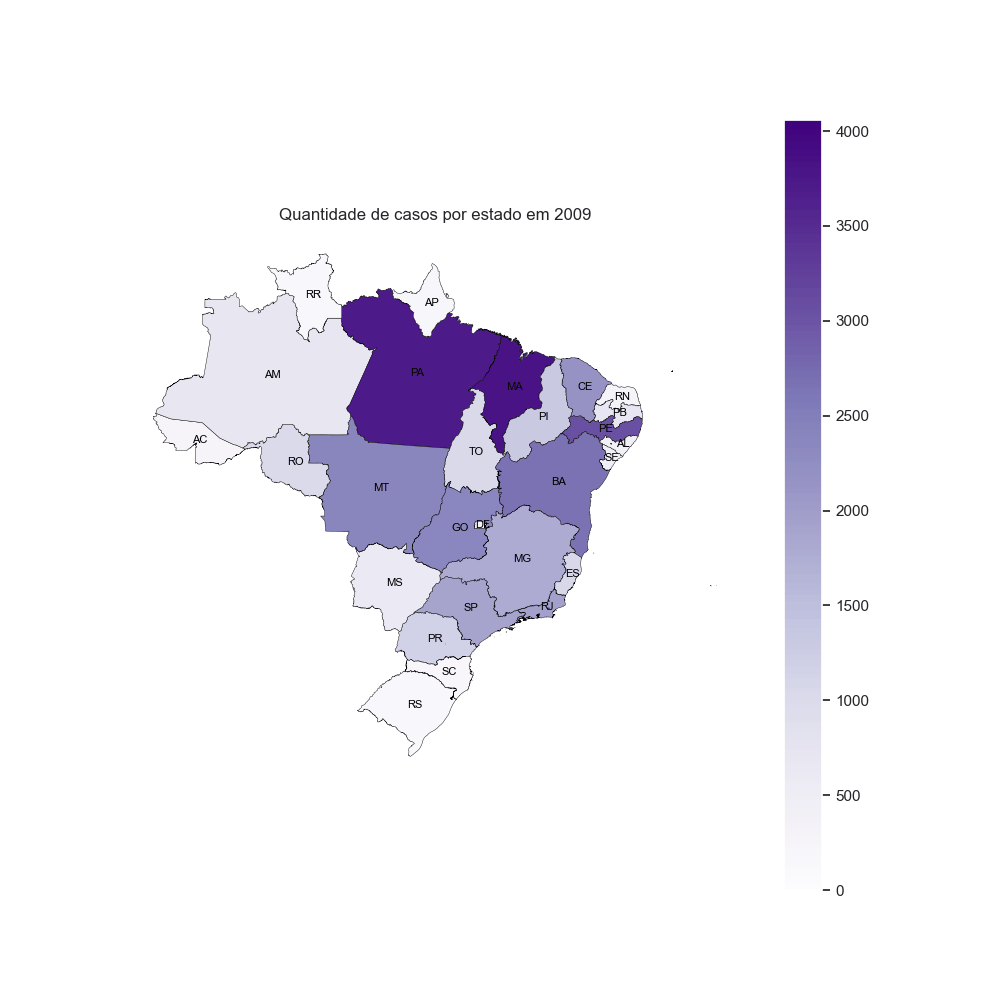

In [45]:
# Exibe o GIF dos casos em cada estado por ano
Image(filename='../assets/graficos/graficos.gif')


### Análise de casos por estado e gravidade

In [13]:
df_hans_severity = df_hans.groupby(['UFATUAL', 'AVALIA_N']).size().reset_index(name='Contagem')
df_hans_severity.head()

,UFATUAL,AVALIA_N,Contagem
0,AC,0.0,1347
1,AC,1.0,290
2,AC,2.0,93
3,AC,3.0,21
4,AL,0.0,1967


#### Grau 0:

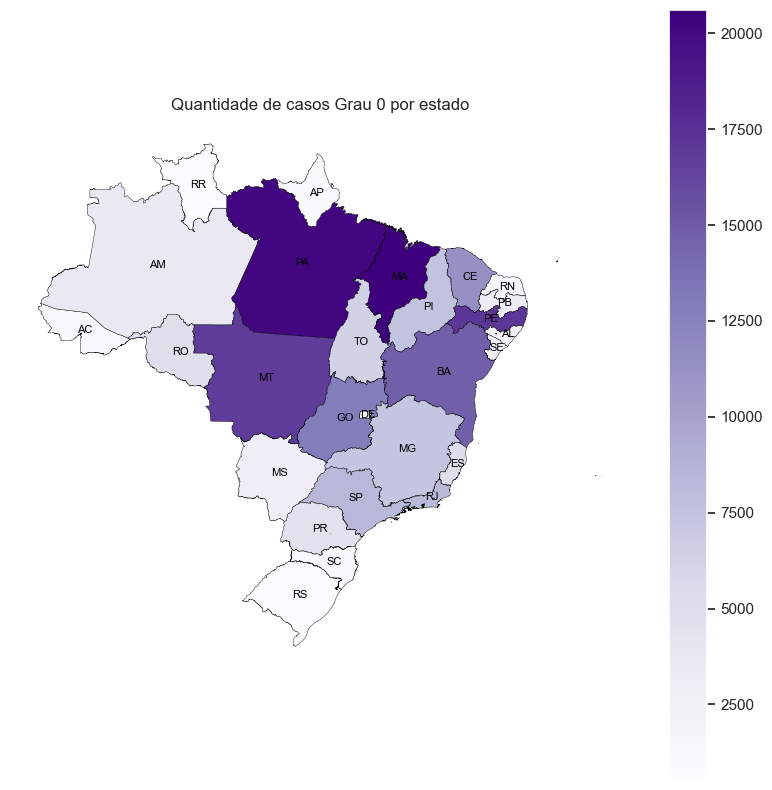

In [14]:
df_hans_severity_0 = df_hans_severity.loc[df_hans_severity['AVALIA_N'] == 0].drop('AVALIA_N', axis=1)

# Combina o DataFrame com o GeoDataFrame do mapa
map_occurrences_0 = map.merge(df_hans_severity_0, left_on='SIGLA_UF', right_on='UFATUAL')

# Plot do mapa do Brasil com os dados
fig, ax = plt.subplots(figsize=(10, 10))
map_occurrences_0.plot(column='Contagem', cmap='Purples', edgecolor='black', linewidth = 0.3, ax=ax, legend=True)

# Adiciona as siglas das UFs
for x, y, label in zip(map_occurrences.geometry.centroid.x, map_occurrences.geometry.centroid.y, map_occurrences['SIGLA_UF']):
    ax.annotate(label, xy=(x, y), xytext=(2, -2), textcoords="offset points", ha='center', fontsize=8, color='black')

ax.set_title('Quantidade de casos Grau 0 por estado')
ax.set_axis_off()
plt.show()

#### Grau I:

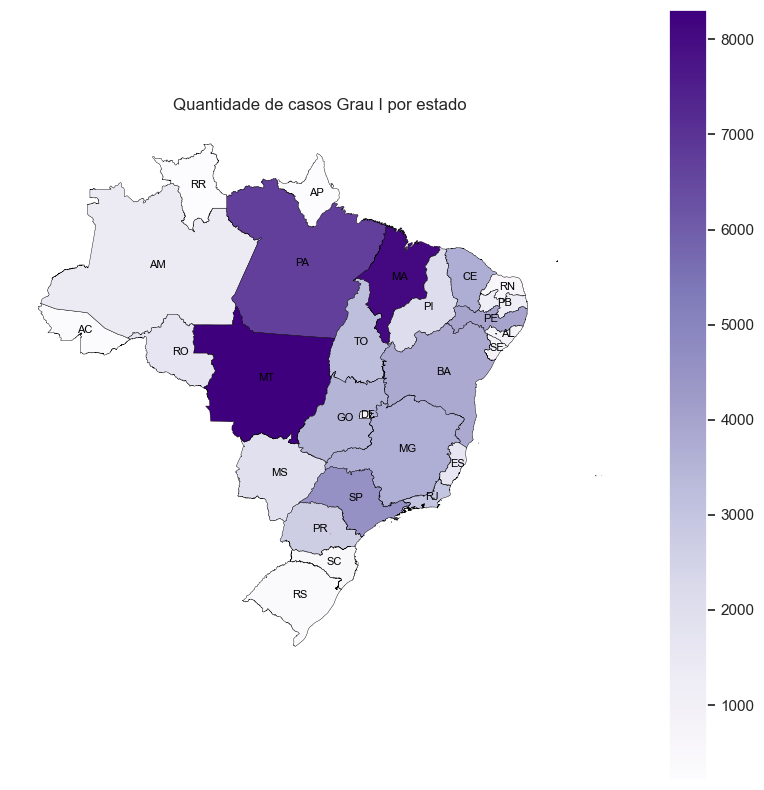

In [15]:

df_hans_severity_1 = df_hans_severity.loc[df_hans_severity['AVALIA_N'] == 1].drop('AVALIA_N', axis=1)

# Combina o DataFrame com o GeoDataFrame do mapa
map_occurrences_1 = map.merge(df_hans_severity_1, left_on='SIGLA_UF', right_on='UFATUAL')

# Plot do mapa do Brasil com os dados
fig, ax = plt.subplots(figsize=(10, 10))
map_occurrences_1.plot(column='Contagem', cmap='Purples', edgecolor='black', linewidth = 0.3, ax=ax, legend=True)

# Adiciona as siglas das UFs
for x, y, label in zip(map_occurrences.geometry.centroid.x, map_occurrences.geometry.centroid.y, map_occurrences['SIGLA_UF']):
    ax.annotate(label, xy=(x, y), xytext=(2, -2), textcoords="offset points", ha='center', fontsize=8, color='black')

ax.set_title('Quantidade de casos Grau I por estado')
ax.set_axis_off()
plt.show()

#### Grau II:

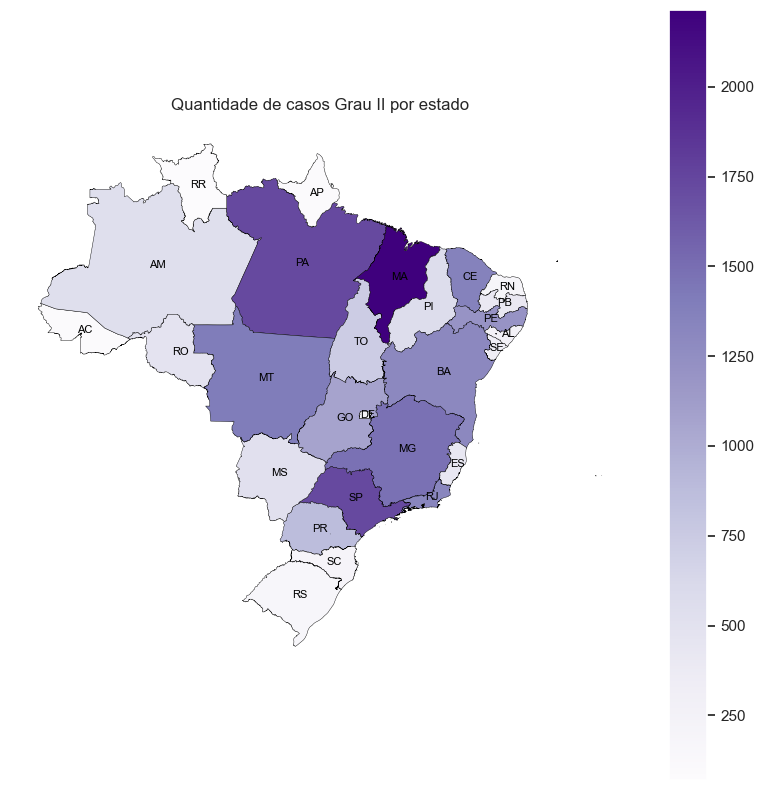

In [16]:
df_hans_severity_2 = df_hans_severity.loc[df_hans_severity['AVALIA_N'] == 2].drop('AVALIA_N', axis=1)

# Combina o DataFrame com o GeoDataFrame do mapa
map_occurrences_2 = map.merge(df_hans_severity_2, left_on='SIGLA_UF', right_on='UFATUAL')

# Plot do mapa do Brasil com os dados
fig, ax = plt.subplots(figsize=(10, 10))
map_occurrences_2.plot(column='Contagem', cmap='Purples', edgecolor='black', linewidth = 0.3, ax=ax, legend=True)

# Adiciona as siglas das UFs
for x, y, label in zip(map_occurrences.geometry.centroid.x, map_occurrences.geometry.centroid.y, map_occurrences['SIGLA_UF']):
    ax.annotate(label, xy=(x, y), xytext=(2, -2), textcoords="offset points", ha='center', fontsize=8, color='black')

ax.set_title('Quantidade de casos Grau II por estado')
ax.set_axis_off()
plt.show()

### Análise do abandono

In [17]:
# Considerar apenas casos com desfecho: cura, óbito ou abandono
df_hans_tp_alta = df_hans[df_hans['TPALTA_N'].isin([1, 6, 7])]

<AxesSubplot:>

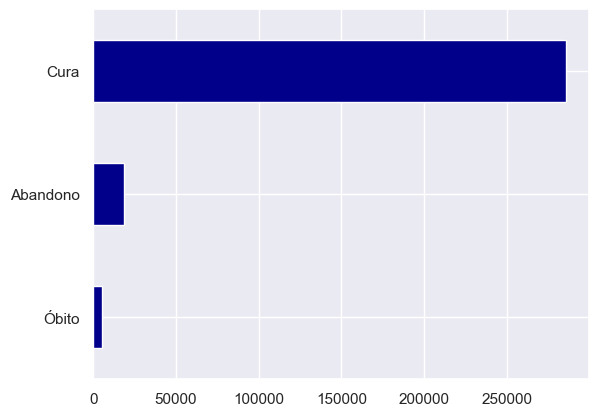

In [18]:
df_hans_outcome = df_hans_tp_alta.copy()
df_hans_outcome['TPALTA_N'] = df_hans_outcome['TPALTA_N'].replace({1: 'Cura', 6: 'Óbito', 7: 'Abandono'})
df_hans_outcome['TPALTA_N'].value_counts().sort_values().plot.barh(color='darkblue')

In [19]:
# Agrupa os dados pelo ano e pelo munícipio da ultima atualização
gp_muni_at = df_hans.groupby(["NU_ANO", "ID_MUNI_AT"], group_keys=False)
# Conta o número de abandonos
count_ab = gp_muni_at['TPALTA_N'].apply(lambda x: (x==7).sum())
# Conta o número de diagnósticos
count_diag = gp_muni_at['DT_DIAG'].count()
count_df = pd.DataFrame(count_diag)
count_df["ABANDONOS"] = count_ab
count_df["PERCENT_AB"] = count_ab/count_diag
count_df

DT_DIAG  ABANDONOS  PERCENT_AB
NU_ANO ID_MUNI_AT                                
2009   110001.0         40          0    0.000000
       110002.0         77          0    0.000000
       110003.0          1          0    0.000000
       110004.0         42          3    0.071429
       110005.0         11          2    0.181818
...                    ...        ...         ...
2019   522160.0         11          1    0.090909
       522170.0          2          0    0.000000
       522180.0          1          0    0.000000
       522205.0          5          1    0.200000
       530010.0        161         23    0.142857

[30205 rows x 3 columns]

In [20]:
# Leitura dos polígonos das cidades brasileiras de uma cópia local
geo = gpd.read_file("../assets/mapa/all_cities.shp")
# Adapta o código das cidades do ibge para a versão utilizada pelo ministério da saúde 
geo["muni"] = geo["code_muni"].astype("string").str.slice(stop=-3).astype("float64")

for year in years_analysis:
    # Combina as contagens de abandono por cidade com o GeoDataFrame do mapa
    map_occurrences = geo.merge(count_df.loc[[year]], how="left", left_on=["muni"], right_on=["ID_MUNI_AT"])

    # Plot do mapa do Brasil com os dados
    fig, ax = plt.subplots(figsize=(10, 10))
    map_occurrences.plot(
        column='PERCENT_AB', cmap='winter_r', edgecolor='black', linewidth = 0.1, ax=ax, legend=True, 
        missing_kwds={"color": "lightgrey", "label": "Sem dados"},
        legend_kwds={"label": "Percentagem de abandono", "orientation": "horizontal", "shrink": 0.6}
    )
    ax.set_title('Porcentagem de abandono em relação ao número de diagnósticos em {}'.format(year))
    ax.set_axis_off()
    
    # Salva a imagem com o nome do ano
    plt.savefig('../assets/graficos/mapa_ab_{}.png'.format(year))
    plt.close()
    
# usar a biblioteca imageio para criar o gif a partir das imagens salvas
imagens = []
for year in years_analysis:
    nome_arquivo = f'../assets/graficos/mapa_ab_{year}.png'
    imagem = imageio.imread(nome_arquivo)
    imagens.append(imagem)

# criar o gif a partir das imagens
imageio.mimsave('../assets/graficos/graficos_ab.gif', imagens, fps=2)

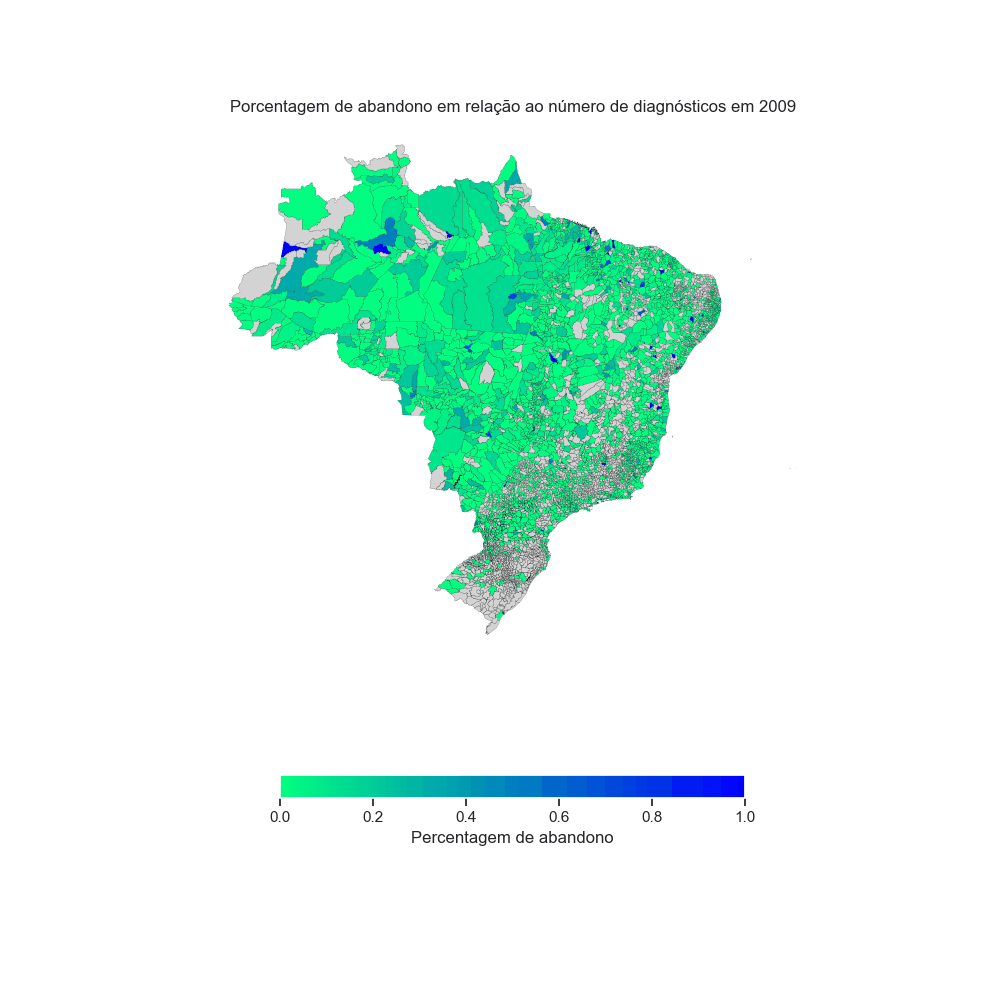

In [21]:
# Exibe o GIF dos casos em cada estado por ano
Image(filename='../assets/graficos/graficos_ab.gif')

In [29]:
# Agrupar abandonos por estado
gp_uf_at = df_hans.groupby(["NU_ANO", "UFATUAL"], group_keys=False)
# Conta o número de abandonos
count_ab = gp_uf_at['TPALTA_N'].apply(lambda x: (x==7).sum())
# Conta o número de diagnósticos
count_diag = gp_uf_at['DT_DIAG'].count()
count_df = pd.DataFrame(count_diag)
count_df["ABANDONOS"] = count_ab
count_df["PERCENT_AB"] = count_ab/count_diag
count_df

DT_DIAG  ABANDONOS  PERCENT_AB
NU_ANO UFATUAL                                
2009   AC           248          3    0.012097
       AL           389         28    0.071979
       AM           702         55    0.078348
       AP           191         31    0.162304
       BA          2651        168    0.063372
...                 ...        ...         ...
2019   RS            69          5    0.072464
       SC           126          9    0.071429
       SE           298         11    0.036913
       SP          1140         85    0.074561
       TO          1348        100    0.074184

[297 rows x 3 columns]

In [46]:

# Leitura dos polígonos dos estados brasileiros de uma cópia local
geo = gpd.read_file("../assets/mapa/BR_UF_2022.shp")

# Max e Min dos valores
vmin = min(count_df["PERCENT_AB"])
vmax = max(count_df["PERCENT_AB"])

for year in years_analysis:    
    # Combina as contagens de abandono por estado com o GeoDataFrame do mapa
    map_occurrences = geo.merge(count_df.loc[[year]], how="left", left_on=["SIGLA_UF"], right_on=["UFATUAL"])

    # Plot do mapa do Brasil com os dados
    fig, ax = plt.subplots(figsize=(10, 10))
    heatmap = map_occurrences.plot(
        column='PERCENT_AB', cmap='winter_r', edgecolor='black', linewidth = 0.3, ax=ax, legend=True, 
        missing_kwds={"color": "lightgrey", "label": "Sem dados"},
        legend_kwds={"label": "Percentagem de abandono", "orientation": "horizontal", "shrink": 0.6},
        vmin=vmin, vmax=vmax
    )
    ax.set_title('Porcentagem de abandono em relação ao número de diagnósticos em {}'.format(year))
    ax.set_axis_off()
    
    # Adiciona as siglas das UFs
    for x, y, label in zip(map_occurrences.geometry.centroid.x, map_occurrences.geometry.centroid.y, map_occurrences['SIGLA_UF']):
        ax.annotate(label, xy=(x, y), xytext=(2, -2), textcoords="offset points", ha='center', fontsize=8, color='black')
    
    # Salva a imagem com o nome do ano
    plt.savefig('../assets/graficos/mapa_ab_uf_{}.png'.format(year))
    plt.close()
    
# usar a biblioteca imageio para criar o gif a partir das imagens salvas
imagens = []
for year in years_analysis:
    nome_arquivo = f'../assets/graficos/mapa_ab_uf_{year}.png'
    imagem = imageio.imread(nome_arquivo)
    imagens.append(imagem)

# criar o gif a partir das imagens
imageio.mimsave('../assets/graficos/graficos_ab_uf.gif', imagens, fps=2)

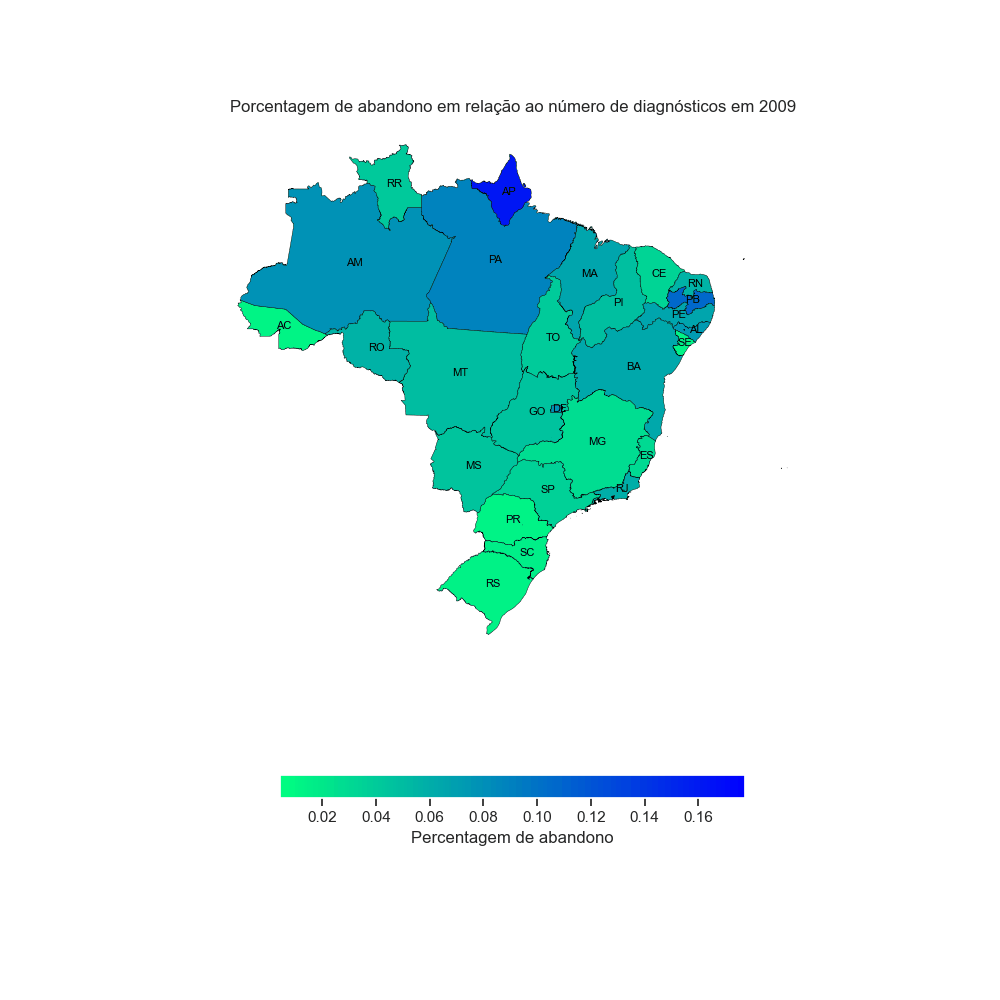

In [47]:
# Exibe o GIF dos casos em cada estado por ano
Image(filename='../assets/graficos/graficos_ab_uf.gif')

In [71]:
# Agrupar abandonos por sexo
gp_mf_at = df_hans.groupby(["NU_ANO", "CS_SEXO"], group_keys=False)
# Conta o número de abandonos
count_ab = gp_mf_at['TPALTA_N'].apply(lambda x: (x==7).sum())
# Conta o número de diagnósticos
count_diag = gp_mf_at['DT_DIAG'].count()
count_df = pd.DataFrame(count_diag)
count_df["ABANDONOS"] = count_ab
count_df["PERCENT_AB"] = (count_ab/count_diag)*100
count_df = count_df.drop('I', level='CS_SEXO')
count_df


DT_DIAG  ABANDONOS  PERCENT_AB
NU_ANO CS_SEXO                                
2009   F          16049        825    5.140507
       M          19609       1131    5.767760
2010   F          14416        662    4.592120
       M          17816        906    5.085317
2011   F          13941        662    4.748583
       M          17448        799    4.579321
2012   F          13272        615    4.633816
       M          16959        914    5.389469
2013   F          13040        658    5.046012
       M          15902        866    5.445856
2014   F          13063        766    5.863890
       M          15649        912    5.827848
2015   F          11531        801    6.946492
       M          14536        933    6.418547
2016   F          10104        662    6.551861
       M          12492        894    7.156580
2017   F          10495        766    7.298714
       M          13021        885    6.796713
2018   F          11659        771    6.612917
       M          13733        982    7.150659
2019   F          11209        975    8.698367
       M          13592       1258    9.255444

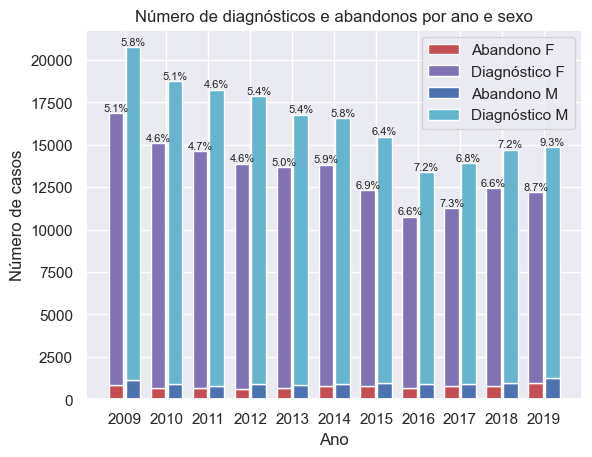

In [72]:
years = count_df.index.get_level_values('NU_ANO').unique()
sexes = count_df.index.get_level_values('CS_SEXO').unique()

bar_width = 0.35
r = np.arange(len(years))
spacing = [0.15-bar_width, -0.15+bar_width]
colors = [['magenta', 'red'], ['cyan', 'blue']]
legend_handles = list()

for i, year in enumerate(years):
    for j, sex in enumerate(sexes):
        aband_bar = plt.bar(r[i] + spacing[j], 
                            count_df['ABANDONOS'].loc[year, sex], 
                            width=bar_width, color=colors[j][1],
                            label=f"Abandonos {sex}")
        legend_handles.append(aband_bar[0])
        
        diag_bar = plt.bar(r[i] + spacing[j], 
                           count_df['DT_DIAG'].loc[year, sex], 
                           width=bar_width, color=colors[j][0], 
                           label=f"Diagnóstico {sex}",
                           bottom=count_df['ABANDONOS'].loc[year, sex])
        legend_handles.append(diag_bar[0])
        
        total = count_df['ABANDONOS'].loc[year, sex] + count_df['DT_DIAG'].loc[year, sex]
        plt.text(r[i] + spacing[j], total, 
                 f'{count_df["PERCENT_AB"].loc[year,sex]:.1f}%', 
                 ha='center', va='bottom', fontsize=8)
    
plt.xlabel("Ano")
plt.ylabel("Número de casos")
plt.title("Número de diagnósticos e abandonos por ano e sexo")

plt.xticks(r, years)
plt.legend(handles=legend_handles, labels=['Abandono F',
                                           'Diagnóstico F',
                                           'Abandono M',
                                           'Diagnóstico M'])